In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import seaborn as sns

In [44]:
train_data = pd.read_csv('./House_price/train.csv')
test_data = pd.read_csv('./House_price/test.csv')

In [45]:
train_data = train_data.reset_index(drop=True)

In [46]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

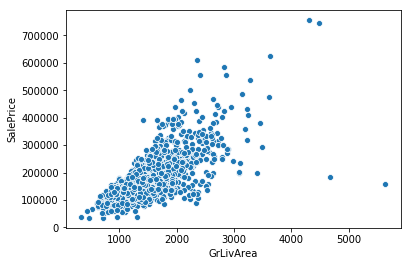

In [47]:
#删掉离群的值
sns.scatterplot(train_data['GrLivArea'], train_data['SalePrice'])

In [48]:
train_data = train_data[(train_data['GrLivArea'] < 4000) | 
                       (train_data['SalePrice'] > 700000)]

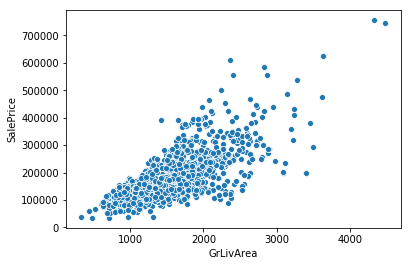

In [49]:
sns.scatterplot(train_data['GrLivArea'], train_data['SalePrice'])

/home/jakey/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


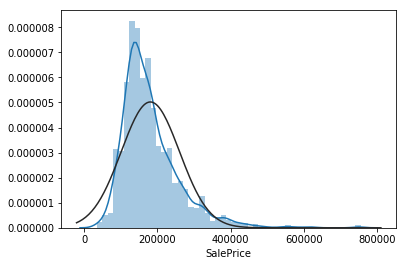

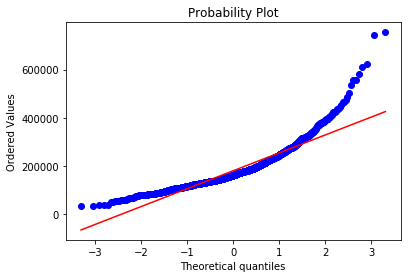

In [50]:
#目标变量的分析
from scipy.stats import *
sns.distplot(train_data['SalePrice'], fit=norm)
fig = plt.figure()
probplot(train_data['SalePrice'], plot=plt)
plt.show()

/home/jakey/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


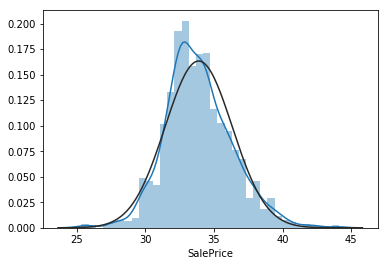

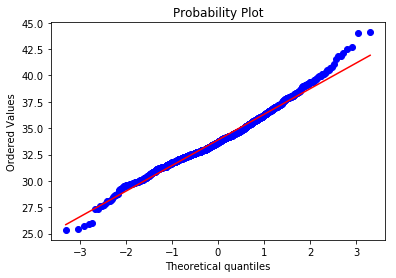

In [51]:
from scipy.special import boxcox1p
train_data['SalePrice'] = boxcox1p(train_data['SalePrice'], 0.15)
sns.distplot(train_data['SalePrice'], fit=norm)
fig = plt.figure()
probplot(train_data['SalePrice'], plot=plt)
plt.show()

In [52]:
train_data[train_data.index==666]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
666,667,60,RL,NaN,18450,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Abnorml,32.282458


In [53]:
n_train = train_data.shape[0]
n_test = test_data.shape[0]
y_train = train_data['SalePrice']
all_data = pd.concat([train_data, test_data], ignore_index=True, sort=False)
all_data.drop(columns=['SalePrice','Id'], inplace=True)
all_data.loc[2574, ['GarageType']] = np.nan
all_data.loc[2124,['GarageType', 'GarageCars', 'GarageArea']] = np.nan
all_data.shape

(2917, 79)

In [54]:
all_data_na = all_data.isnull().sum()/len(all_data)*100
all_data_na = all_data_na[all_data_na.values != 0]
all_data_na = pd.DataFrame({'Miss':all_data_na.sort_values(ascending=False)})

Text(0,0.5,'Percent of missing values')

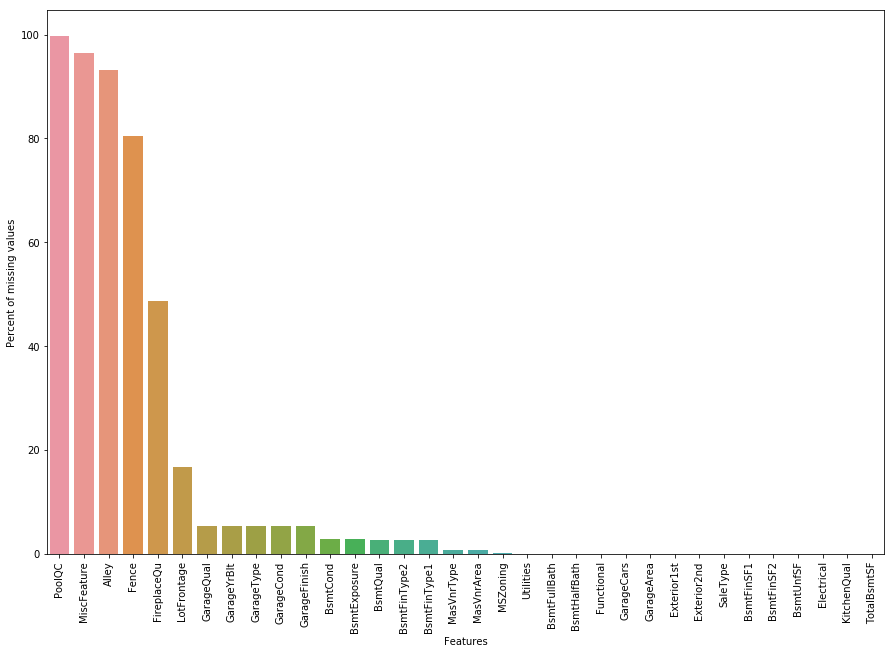

In [55]:
plt.figure(figsize=(15, 10))
sns.barplot(all_data_na.index, all_data_na['Miss'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percent of missing values')

In [56]:
#泳池质量
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

In [57]:
#一些其它维度没有提及的杂项
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

In [58]:
#小巷的类型?
all_data['Alley'] = all_data['Alley'].fillna('None')

In [59]:
#围栏的质量
all_data['Fence'] = all_data['Fence'].fillna('None')

In [60]:
#壁炉的质量
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

transform:<br>
1.只允许在同一时间在一个Series上进行一次转换，如果定义列‘a’ 减去列‘b’，  则会出现异常；<br>
2.必须返回与 group相同的单个维度的序列（行）<br>
apply:<br>
1.不同于transform只允许在Series上进行一次转换， apply对整个DataFrame作用<br>
2.apply隐式地将group 上所有的列作为自定义函数<br>

In [61]:
#到繁华街道的英里数
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

In [62]:
#车库的内部装饰
len(all_data[all_data['GarageFinish'].isna()])

159

In [63]:
#车库建成的日期
len(all_data[all_data['GarageYrBlt'].isna()])

159

In [64]:
#车库质量
len(all_data[all_data['GarageQual'].isna()])

159

In [65]:
#车库情况
len(all_data[all_data['GarageCond'].isna()])

159

In [66]:
#车库的地点
len(all_data[all_data['GarageType'].isna()])

159

In [67]:
#车库能放车的数量
all_data[all_data['GarageCars'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2124,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,Shed,1000,9,2008,WD,Normal
2574,70,RM,50.0,9060,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,None,MnPrv,None,0,3,2007,WD,Alloca


In [68]:
#车库的大小
len(all_data[all_data['GarageArea']==0])

157

In [69]:
#车库的地点，
for col in ['GarageType', 'GarageCond', 'GarageQual', 'GarageFinish']:
    all_data[col] = all_data[col].fillna('None')

In [70]:
for col in ['GarageArea', 'GarageCars', 'GarageYrBlt']:
    all_data[col] = all_data[col].fillna(0)

In [71]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode().iloc[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode().iloc[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [72]:
#检查缺失值
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [73]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['GrLivArea']

In [74]:
all_data.dtypes[all_data.dtypes != object].index.shape

(37,)

In [75]:
all_data.loc[:, ['MSSubClass', 'OverallCond', 'MoSold', 'YrSold']] = all_data.loc[:, ['MSSubClass', 'OverallCond', 'MoSold', 'YrSold']].astype(str)

In [76]:
skew_index = all_data.dtypes[all_data.dtypes != object].index.values
skew = all_data[skew_index].skew().sort_values(ascending=False)
skew = pd.DataFrame({'SKEW':skew})
skew.shape

(33, 1)

In [77]:
#数值偏度问题
skew_feature = skew[skew['SKEW'] > 0.75].index
for col in skew_feature:
    all_data[col] = boxcox1p(all_data[col], 0.15)

In [78]:
#
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for c in cols:
    lbl = LabelEncoder() 
    all_data[c] = lbl.fit_transform(list(all_data[c].values))

In [79]:
all_data = pd.get_dummies(all_data)

In [80]:
train = all_data[:n_train]
test = all_data[n_train:]

In [90]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin, RegressorMixin, clone, BaseEstimator
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
#import lightgbm as lgb

In [82]:
#使用cross_val_score来测试模型的正确率，在这之前，先打乱数据进行k交叉验证
def rmsle_cv(model):
    n_folds = 5
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train.values, scoring='neg_mean_squared_error', cv=kf))
    return(rmse)

In [83]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0028, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=1,
    selection='cyclic', tol=0.0013, warm_start=False))

In [87]:
ENet = ElasticNet()
cross_validation = KFold(n_splits=10)
parameter_grid = {'alpha':[0.0019,0.002,0.0018,0.0015,0.001],
                 'l1_ratio':[0.9,1,1.1,1.2,1.3,1.4,1.5,1.6],
                  'max_iter':[1000],
                 'tol':[0.009,0.01,0.11,0.12,0.2],
                 'random_state':[1]}
grid_search = GridSearchCV(ENet,
                          param_grid=parameter_grid,
                          cv=cross_validation,
                          n_jobs=10)
grid_search.fit(train.values,y_train.values)
grid_search.best_score_,grid_search.best_params_,grid_search.best_estimator_

(0.9259383414963783,
 {'alpha': 0.0019,
  'l1_ratio': 1.1,
  'max_iter': 1000,
  'random_state': 1,
  'tol': 0.01},
 ElasticNet(alpha=0.0019, copy_X=True, fit_intercept=True, l1_ratio=1.1,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=1, selection='cyclic', tol=0.01, warm_start=False))

In [88]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0019, copy_X=True, fit_intercept=True, l1_ratio=1.1,
       max_iter=1000, normalize=False, positive=False, precompute=False,
       random_state=1, selection='cyclic', tol=0.01, warm_start=False))

In [165]:
KRR = KernelRidge()
cross_validation = KFold(n_splits=10)
parameter_grid = {'alpha':[7040,7050,7070,7090,7030,7100],
                  'kernel':['polynomial'],
                  'degree':[2],
                  'coef0':[9.5,9.9,10,10.1,10.5,10.912]
                 }
grid_search = GridSearchCV(KRR,
                          param_grid = parameter_grid,
                          cv=cross_validation,
                          n_jobs=10)
grid_search.fit(train.values,y_train.values)
grid_search.best_score_,grid_search.best_params_,grid_search.best_estimator_

(0.9256351406650716,
 {'alpha': 7030, 'coef0': 10, 'degree': 2, 'kernel': 'polynomial'},
 KernelRidge(alpha=7030, coef0=10, degree=2, gamma=None, kernel='polynomial',
       kernel_params=None))

In [147]:
KRR = KernelRidge(alpha=7030, coef0=10, degree=2, gamma=None,
       kernel='polynomial', kernel_params=None)

In [173]:
GBoost = GradientBoostingRegressor()
cross_validation = KFold(n_splits=10)
parameter_grid = {
                 'n_estimators':[320],
#                  'loss':['huber'],
                 'learning_rate':[0.12],
#                  'subsample':[0.9,0.8],
                 'min_samples_split':np.arange(100,801,200),
                 'max_depth':np.arange(3,14,2),
#                  'random_state':[1,2,3,4,5],
#                  'max_features':['sqrt'],
#                  'alpha':[0.9,0.5,1.5],
                 }
grid_search = GridSearchCV(GBoost,
                          param_grid=parameter_grid,
                          cv=cross_validation,
                          n_jobs=10
                          )
grid_search.fit(train.values,y_train.values)
grid_search.best_score_,grid_search.best_params_,grid_search.best_estimator_

(0.9173724015229354,
 {'learning_rate': 0.12,
  'max_depth': 9,
  'min_samples_split': 500,
  'n_estimators': 320},
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='ls', max_depth=9, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=500, min_weight_fraction_leaf=0.0,
              n_estimators=320, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))

In [175]:
GBoost = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='ls', max_depth=8, max_features=24,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=15,
              min_samples_split=930, min_weight_fraction_leaf=0.0,
              n_estimators=320, presort='auto', random_state=6, subsample=1,
              verbose=0, warm_start=False)

In [176]:
kfold = KFold(n_splits=10)
cross_val_score(GBoost,train.values,y_train.values, cv=kfold, n_jobs=10).mean()

0.919868867746325

In [178]:
cross_val_score(lasso,train.values,y_train.values, cv=kfold, n_jobs=10).mean()

0.9261003142324059

In [179]:
cross_val_score(ENet,train.values,y_train.values, cv=kfold, n_jobs=10).mean()

0.9262448190444781

In [180]:
cross_val_score(KRR,train.values,y_train.values, cv=kfold, n_jobs=10).mean()

0.9205716117004421

In [182]:
class StackAveragedModel(RegressorMixin,BaseEstimator,TransformerMixin):
    def __init__(self,base_model, meta_model,n_folds=5):
        self.base_model = base.model
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, X, Y):
        self.base_model_ = [list() for x in self.base_model]
        self.meta_model_ = clone(meta_model)
        kfold = KFold(n_splits=n_folds,shuffle=False,random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_model)))
        for i, model in enumerate(self.base_model):
            for train_index, holdout_index in kfold.split(X, Y):
                instance = clone(model)
                self.base_model_[i].append(model)
                instance.fit(X[train_index], Y[holdout_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
            self.meta_model_.fit(out_of_fold_predictions, Y)
        return self
    
    def predict(self, X):
        meta_feature = np.column_stack([
            np.column_stack([model.predict(x) for model in base_models]).mean(axis=1)
            for base_models in self.base_model_
        ])
        return self.meta_model_.predict(meta_feature)